## Этап 1. Открываю данные и получаю общую информацию о датасете

### Импортирую библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import lightgbm as lgb
import warnings

In [2]:
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
#приводим названия столбцов к стандарту
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 
              'gearbox', 'power', 'model', 'kilometer', 'registration_month',
             'fuel_type', 'brand', 'repaired', 'date_created', 'number_of_pictures',
             'postal_code', 'last_seen']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [6]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Оцениваю количество пропусков

In [7]:
def isna(data):
    data_isna = data.isna().sum()
    data_isna_percentage = ((data_isna / len(data)) * 100).round(2)
    data_isna_df = pd.DataFrame({
    'Количество пропусков': data_isna,
    'Процент пропусков': data_isna_percentage
}) 
    return data_isna_df[(data_isna_df['Количество пропусков'] > 0)].sort_values(
        by='Количество пропусков', ascending=False)

In [8]:
df_isna = isna(df)
df_isna

,Количество пропусков,Процент пропусков
repaired,71154,20.08
vehicle_type,37490,10.58
fuel_type,32895,9.28
gearbox,19833,5.60
model,19705,5.56


### Проверю датафрейм на наличие дубликатов

In [9]:
#подсчитываем явные дубликаты
df.duplicated().sum()

4

In [10]:
#удаляем дубликаты
df = df.drop_duplicates().reset_index(drop=True)

## Этап 2. Предобработка данных

### Рассмотрим количественные признаки

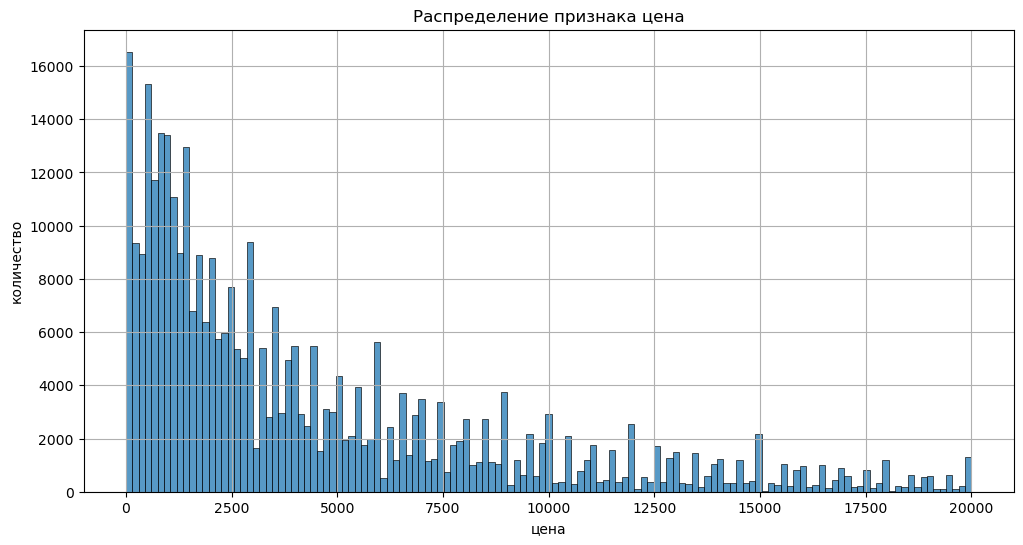

In [11]:
#строим гистограмму для анализа данных по ценам
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='price')
plt.title('Распределение признака цена')
plt.xlabel('цена')
plt.ylabel('количество')
plt.grid()
plt.show()

In [12]:
#считаем количество объектов с нулевой ценой
len(df[df['price'] == 0])

10772

Видим аномальное значение 0 для цены автомобиля у 10772 объектов. 

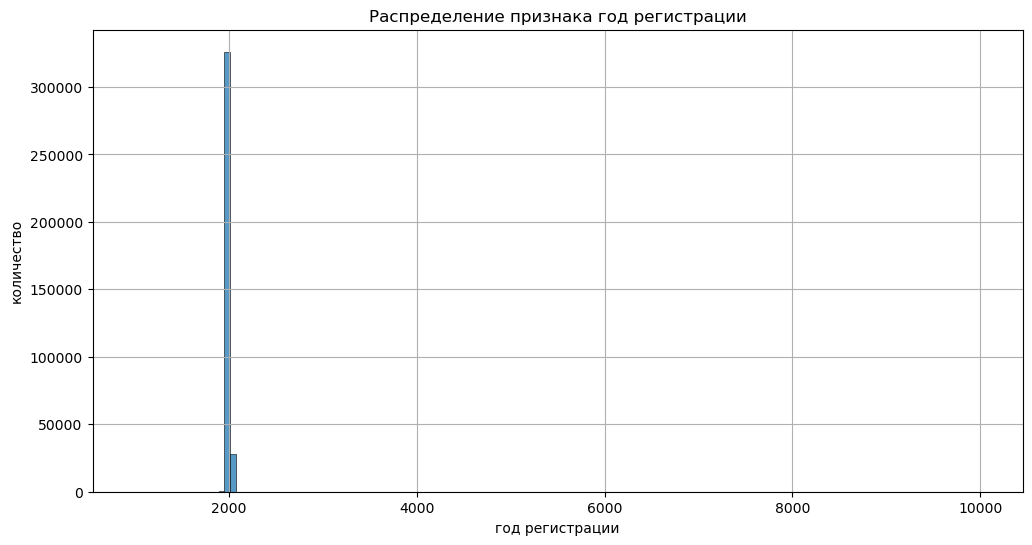

In [13]:
#строим гистограмму для анализа данных по годам регистрации
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='registration_year', 
             bins=len(df['registration_year'].sort_values().unique()))
plt.title('Распределение признака год регистрации')
plt.xlabel('год регистрации')
plt.ylabel('количество')
plt.grid()
plt.show()

In [14]:
#считаем количество объектов с аномальными годами регистрации
len(df[(df['registration_year'] <= 1950) | (df['registration_year'] >= 2023)])

369

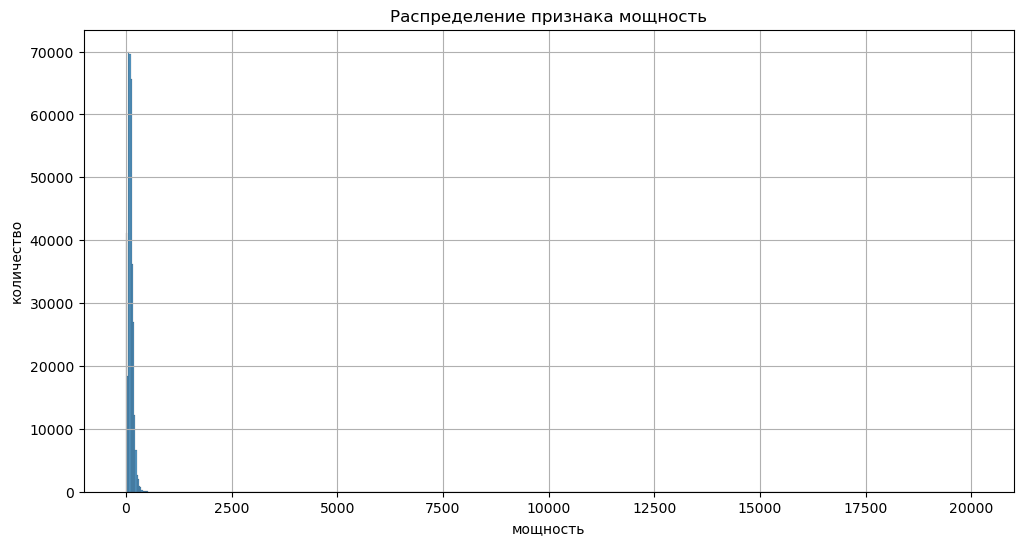

In [15]:
#строим гистограмму для анализа данных по мощности
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='power', bins=len(df['power'].sort_values().unique()))
plt.title('Распределение признака мощность')
plt.xlabel('мощность')
plt.ylabel('количество')
plt.grid()
plt.show()

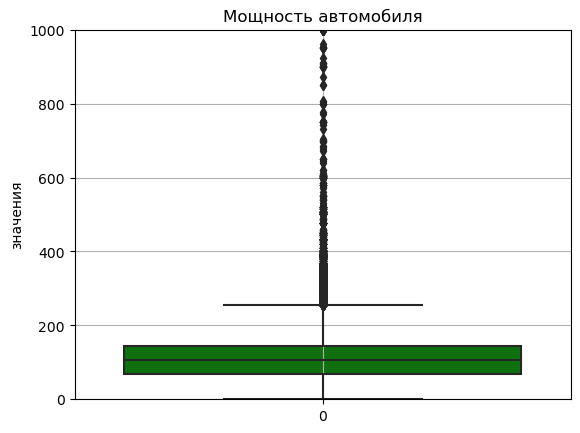

In [16]:
#строим boxplot для анализа данных по мощности
boxplot_power = sns.boxplot(data=df['power'], color='green')
boxplot_power.set_title('Мощность автомобиля')
boxplot_power.set_ylabel('значения')
boxplot_power.set_ylim([0, 1000])
plt.grid()
plt.show()

In [17]:
#считаем количество объектов с аномальной мощностью
len(df[(df['power'] >= 500)])

498

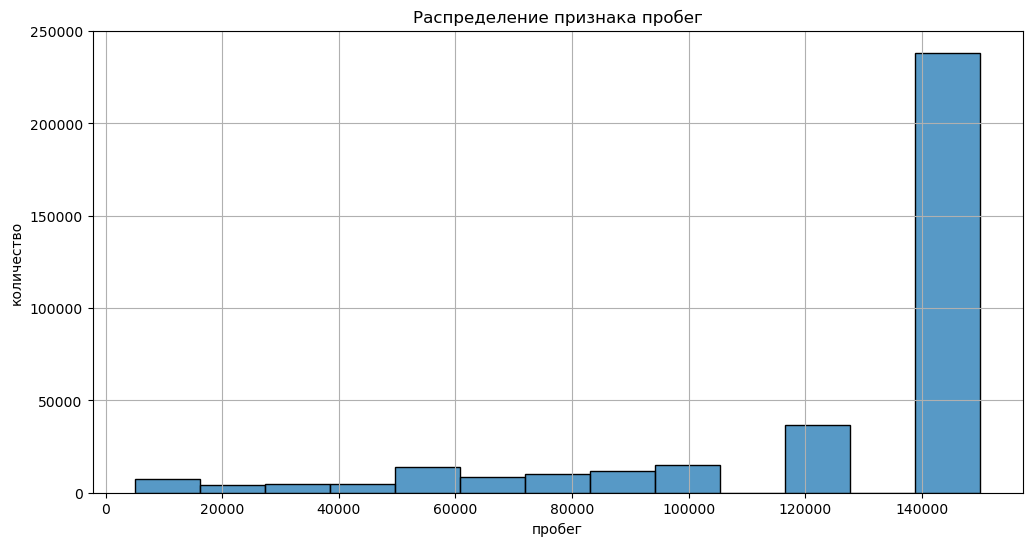

In [18]:
#строим гистограмму для анализа данных по пробегу
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='kilometer',
            bins=len(df['kilometer'].sort_values().unique()))
plt.title('Распределение признака пробег')
plt.xlabel('пробег')
plt.ylabel('количество')
plt.grid()
plt.show()

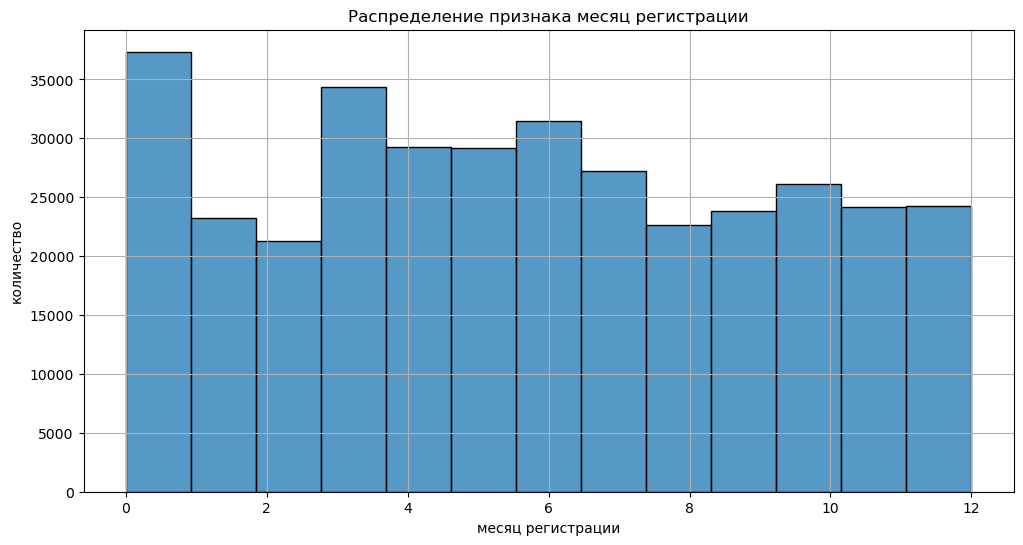

In [19]:
#строим гистограмму для анализа данных по месяцу регистрации
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='registration_month',
            bins=len(df['registration_month'].sort_values().unique()))
plt.title('Распределение признака месяц регистрации')
plt.xlabel('месяц регистрации')
plt.ylabel('количество')
plt.grid()
plt.show()

In [20]:
#проверяем какие значения встречаются для месяцев регистрации
df['registration_month'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

Видим нарушение логики, в датафрейме 13 месяцев.

In [21]:
#проверяем какие значения встречаются в количестве фотографий
df['number_of_pictures'].sort_values().unique()

array([0])

In [22]:
#оцениваю количество уникальных данных в почтовом коде
len(df['postal_code'].unique())

8143

### Вывод

Для дальнейшего исследования мы можем исключить следующие признаки:
- date_crawled, т.к. дата скачивания анкеты не влияет на целевой признак (цену);
- date_created, исключаем по аналогичной причине;
- last_seen, также не влияет;
- registration_month, т.к. для исследования нам будет достаточно года регистрации;
- number_of_pictures, т.к. их значения для всех объектов равны 0
- postal_code, с одной стороны информация о регионе, которая зашита в почтовый код может быть полезной, с другой стороны в датафрейме слишком большое количество уникальных значений почтовых кодов, которая может быть излишней для цели обучения.


In [23]:
#исключаем нерелевантные цели исследования признаки
df = df.drop(columns=['date_crawled', 'date_created', 'last_seen', 'registration_month',
                     'number_of_pictures', 'postal_code'])

In [24]:
#исключаем объекты с аномальным значением цены, мощности, для года регистрации оставим более актуальный период
df = df[df['price'] > 0]
df = df[(df['power'] > 0) & (df['power'] <= 500)]
df = df[(df['registration_year'] >= 1980) & (df['registration_year'] <= 2016)]

### Рассмотрим категориальные признаки.

In [25]:
#рассмотрим уникальные значения признака тип кузова
df['vehicle_type'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

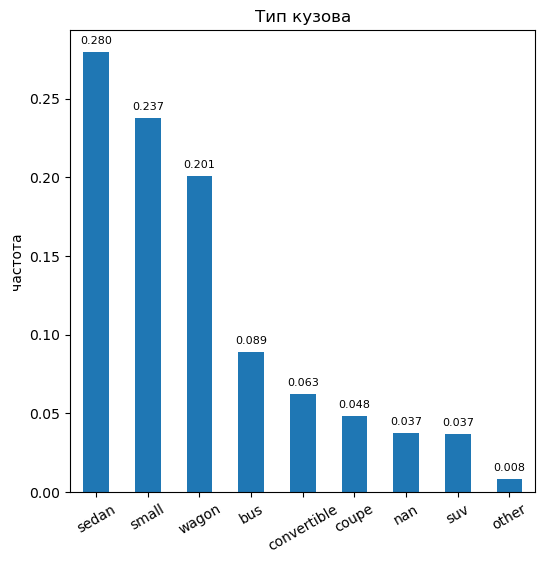

In [26]:
#посмотрим распределение
barplot1 = df['vehicle_type'].value_counts(normalize=True,
                                          dropna=False).plot(kind='bar', 
                                                       figsize=(6,6), 
                                                       title='Тип кузова')
plt.xticks(rotation=30)
plt.ylabel('частота')
for bar in barplot1.patches:
    barplot1.annotate(format(bar.get_height(), '.3f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
    
plt.show()

In [27]:
#заменяем пропуски для тип кузова на unknown
df['vehicle_type'] = df['vehicle_type'].fillna('unknown')

In [28]:
#строим сводную таблицу по брендам
df_brand = df.pivot_table(index=['brand', 'model', 'vehicle_type'], 
                          values='price', aggfunc='count')

In [29]:
#сделаем срез, чтобы посмотреть на распределение значений внутри одной модели бренда
df_brand.loc['audi', 'tt']

,price
vehicle_type,
convertible,390
coupe,589
other,1
sedan,2
small,5
unknown,21


In [30]:
#сделаем срез, чтобы посмотреть на распределение значений внутри одной модели бренда
df_brand.loc['audi', 'a6']

,price
vehicle_type,
bus,1
other,3
sedan,1687
small,1
suv,7
unknown,72
wagon,3185


Оставляем на месте пропусков в типе кузова заглушку 'unknown', так как точное значение подобрать невозможно.

In [31]:
#рассмотрим уникальные значения по типу коробки передач
df['gearbox'].sort_values().unique()

array(['auto', 'manual', nan], dtype=object)

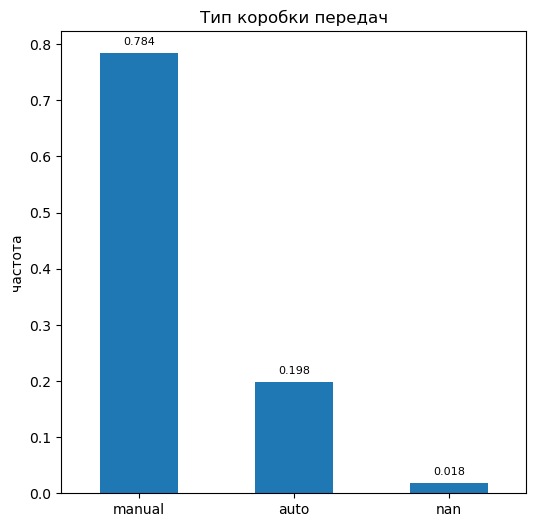

In [32]:
#посмотрим распределение
barplot2 = df['gearbox'].value_counts(normalize=True,
                                     dropna=False).plot(kind='bar', 
                                                       figsize=(6,6), 
                                                       title='Тип коробки передач')
plt.xticks(rotation=0)
plt.ylabel('частота')
for bar in barplot2.patches:
    barplot2.annotate(format(bar.get_height(), '.3f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
    
plt.show()

In [33]:
#заменяем пропуски на unknown
df['gearbox'] = df['gearbox'].fillna('unknown')

In [34]:
#строим сводную таблицу по коробке передач
df_gearbox = df.pivot_table(index=['brand', 'model', 
                                   'registration_year', 'gearbox'], 
                            values='price', aggfunc='count')

In [35]:
#сделаем срез, чтобы посмотреть на распределение значений внутри одной модели бренда по годам
df_gearbox.loc['audi', 'tt']

price
registration_year gearbox       
1990              manual       1
1998              manual      24
1999              auto         1
                  manual     146
                  unknown      2
2000              manual     154
                  unknown      2
2001              manual      89
2002              manual      57
2003              auto        19
                  manual      38
2004              auto        20
                  manual      38
2005              auto         7
                  manual      32
2006              auto        22
                  manual      41
                  unknown      6
2007              auto        45
                  manual      93
2008              auto        22
                  manual      65
                  unknown      1
2009              auto         8
                  manual      31
2010              auto         1
                  manual      20
2011              manual      12
2012              manual       2
2014              manual       1
2015              auto         1
2016              auto         1
                  manual       5
                  unknown      1

В отдельные годы для определенных моделей можно найти наиболее вероятный тип коробки передач, но системно заполнить эти пропуски невозможно, поэтому оставляем заглушку 'unknown'.

In [36]:
#считаем количество уникальных значений в моделях
len(df['model'].sort_values().unique())

249

In [37]:
#заменяем пропуски на unknown
df['model'] = df['model'].fillna('unknown')

Заменить системно пропуски в названиях моделей по имеющимся данным невозможно.

In [38]:
#смотрим уникальные значения для типа топлива
df['fuel_type'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

In [39]:
#объединяем gasoline и petrol, потому что это синонимы
df['fuel_type'] = df['fuel_type'].str.replace('gasoline', 'petrol', regex=True)

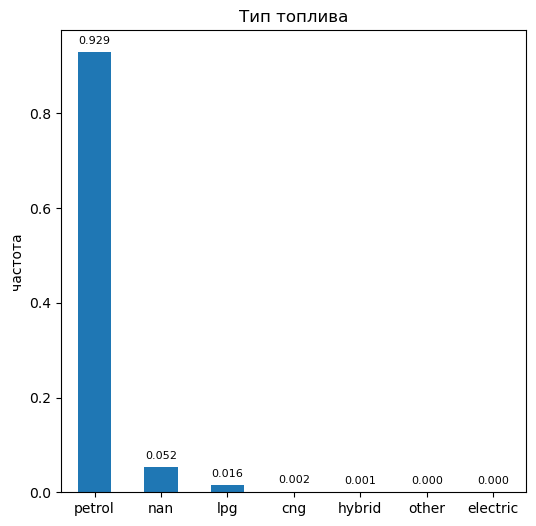

In [40]:
barplot3 = df['fuel_type'].value_counts(normalize=True,
                                     dropna=False).plot(kind='bar', 
                                                       figsize=(6,6), 
                                                       title='Тип топлива')
plt.xticks(rotation=0)
plt.ylabel('частота')
for bar in barplot3.patches:
    barplot3.annotate(format(bar.get_height(), '.3f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
    
plt.show()

In [41]:
#Заменяем пропуски на other (возможно это дизель, но мы не можем точно утверждать)
df['fuel_type'] = df['fuel_type'].fillna('other')

In [42]:
#Также можем объединить все остальные значения кроме petrol в категорию other
other_fuel = ['cng', 'electric', 'hybrid', 'lpg']
for i in other_fuel:
    df['fuel_type'] = df['fuel_type'].str.replace(i, 'other', regex=True)

In [43]:
#получаем следующее распределение
df['fuel_type'].value_counts(normalize=True)

petrol    0.928864
other     0.071136
Name: fuel_type, dtype: float64

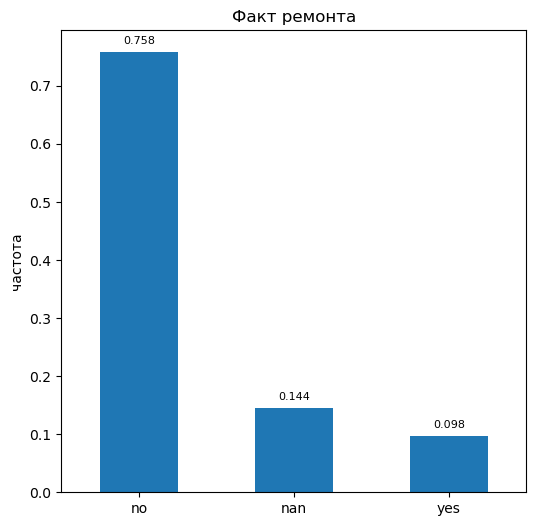

In [44]:
barplot4 = df['repaired'].value_counts(normalize=True,
                                     dropna=False).plot(kind='bar', 
                                                       figsize=(6,6), 
                                                       title='Факт ремонта')
plt.xticks(rotation=0)
plt.ylabel('частота')
for bar in barplot4.patches:
    barplot4.annotate(format(bar.get_height(), '.3f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')
    
plt.show()

In [45]:
#Заменяем пропуски на unknown 
df['repaired'] = df['repaired'].fillna('unknown')

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294294 entries, 1 to 354364
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              294294 non-null  int64 
 1   vehicle_type       294294 non-null  object
 2   registration_year  294294 non-null  int64 
 3   gearbox            294294 non-null  object
 4   power              294294 non-null  int64 
 5   model              294294 non-null  object
 6   kilometer          294294 non-null  int64 
 7   fuel_type          294294 non-null  object
 8   brand              294294 non-null  object
 9   repaired           294294 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.7+ MB


In [47]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [48]:
#применяем порядковое кодирование для категориальных признаков
encoder = OrdinalEncoder()
df_encodered = pd.DataFrame(encoder.fit_transform(df),
                            columns=df.columns)

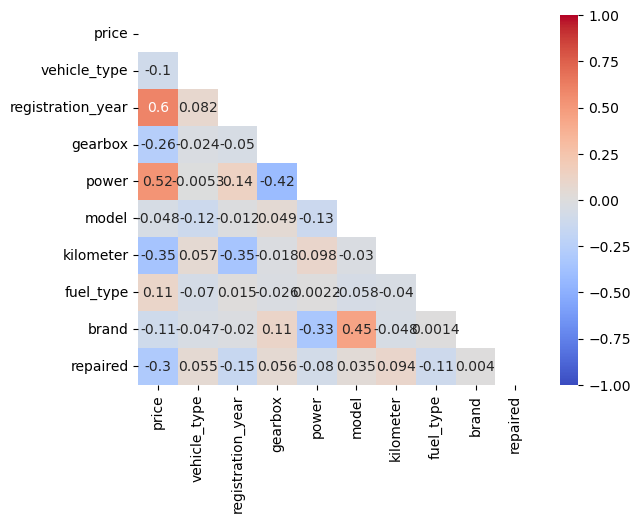

In [49]:
#строим тепловую карту корреляции
upp_mat_1 = np.triu(df_encodered.corr())
sns.heatmap(df_encodered.corr(), vmin =-1, vmax=1, annot=True, cmap='coolwarm', mask=upp_mat_1) 
plt.show()

Наиболее сильно выражена связь у параметров у целевого признака цена с признаками мощность и год регистрации.

## Этап 3. Обучение моделей

In [50]:
#функция целевой метрики RMSE
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return mse ** 0.5

In [51]:
#задаем метрику качества для моделей
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [52]:
#определяем признаки и целевой признак
features = df.drop('price', axis=1)
target = df['price']

In [53]:
#разделяем обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [54]:
#проверяем размеры выборок
print(features_train.shape)
print(features_test.shape)

(220720, 9)
(73574, 9)


Порядковое кодирование признаков.

In [55]:
encoder2 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=5555)

In [56]:
#фитим порядковое кодинирование на обучающей выборке
encoder2.fit(features_train)

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=5555)

In [57]:
features_train_enc = encoder2.transform(features_train)
features_test_enc = encoder2.transform(features_test)

In [58]:
features_train_enc = pd.DataFrame(features_train_enc, columns=features.columns)
features_test_enc = pd.DataFrame(features_test_enc, columns=features.columns)

Масштабирование признаков.

In [59]:
scaler = StandardScaler()

In [60]:
scaler.fit(features_train_enc)

StandardScaler()

In [61]:
features_train_scal = scaler.transform(features_train_enc)
features_test_scal = scaler.transform(features_test_enc)

In [62]:
features_train_scal = pd.DataFrame(features_train_scal, columns=features.columns)
features_test_scal = pd.DataFrame(features_test_scal, columns=features.columns)

### Random Forest 

In [63]:
%%time
model_1 = RandomForestRegressor(random_state=12345)
parametrs_1 = ({'max_depth': range(2,30,2),
              'n_estimators': range(5,55,10)})
grid_model_1 = GridSearchCV(model_1, parametrs_1, scoring=rmse_scorer)
grid_model_1.fit(features_train_scal, target_train)
grid_model_1.best_params_

CPU times: user 28min 5s, sys: 7.96 s, total: 28min 13s
Wall time: 28min 14s


{'max_depth': 18, 'n_estimators': 45}

In [64]:
%%time
best_rf_model = RandomForestRegressor(random_state=12345, max_depth=18,
                                           n_estimators=45)
best_rf_model.fit(features_train_scal, target_train)

CPU times: user 13 s, sys: 47.4 ms, total: 13.1 s
Wall time: 13.1 s


RandomForestRegressor(max_depth=18, n_estimators=45, random_state=12345)

In [65]:
%%time
pred1 = best_rf_model.predict(features_train_scal)

CPU times: user 1.54 s, sys: 8.47 ms, total: 1.55 s
Wall time: 1.55 s


In [67]:
model_1_score = abs(grid_model_1.best_score_)
print('RMSE модели', model_1_score)

RMSE модели 1570.5084287257419


### CatBoost

In [69]:
category_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [77]:
%%time
model_2 = CatBoostRegressor(cat_features=category_features, random_state=12345,
                           verbose=20000)                       
parameters_2 = {'iterations': [100, 150, 200, 250, 300],
                'learning_rate': [0.03, 0.06, 0.09, 0.12],
               'depth': [2, 4, 6, 8, 10]}
grid_model_2 = GridSearchCV(estimator=model_2, param_grid=parameters_2, cv=2, n_jobs=-1,
                           scoring=rmse_scorer)
grid_model_2.fit(features_train, target_train)
grid_model_2.best_params_

0:	learn: 4186.7907666	total: 96.1ms	remaining: 28.7s
299:	learn: 1421.5253886	total: 18.2s	remaining: 0us
CPU times: user 1min 54s, sys: 4.46 s, total: 1min 59s
Wall time: 8min 15s


{'depth': 10, 'iterations': 300, 'learning_rate': 0.12}

In [78]:
%%time
best_cat_model = CatBoostRegressor(cat_features=category_features, random_state=12345,
                                  iterations=300, depth=10, learning_rate=0.12,
                                  verbose=1000)
best_cat_model.fit(features_train, target_train)

0:	learn: 4186.7907666	total: 72.2ms	remaining: 21.6s
299:	learn: 1421.5253886	total: 18.4s	remaining: 0us
CPU times: user 1min 47s, sys: 3.12 s, total: 1min 50s
Wall time: 18.7 s


In [79]:
%%time
pred2 = best_cat_model.predict(features_train)

CPU times: user 790 ms, sys: 9.83 ms, total: 799 ms
Wall time: 237 ms


In [80]:
model_2_score = abs(grid_model_2.best_score_)
print('RMSE модели', model_2_score)

RMSE модели 1561.8209990437233


### LightGBM

In [86]:
%%time
model_3 = lgb.LGBMRegressor(random_state=12345)
parameters_3 = {'num_leaves': [20,40,60,80], 
                'min_child_samples': [5,10,15],
                'max_depth': [5,10,15],
                 'learning_rate':[0.03, 0.06, 0.09, 0.12],
                'reg_alpha':[0,0.01,0.03]}
grid_model_3 = GridSearchCV(estimator=model_3, param_grid=parameters_3, cv=2,
                           scoring=rmse_scorer)
grid_model_3.fit(features_train_scal, target_train)
grid_model_3.best_params_

CPU times: user 1h 35min 40s, sys: 17min 7s, total: 1h 52min 47s
Wall time: 22min 21s


{'learning_rate': 0.12,
 'max_depth': 15,
 'min_child_samples': 10,
 'num_leaves': 80,
 'reg_alpha': 0.01}

In [87]:
%%time
best_model_lgbm = lgb.LGBMRegressor(random_state=12345, learning_rate=0.12,
                                   max_depth=15, min_child_samples=10, num_leaves=80,
                                   reg_alpha=0.03)
best_model_lgbm.fit(features_train_scal, target_train)

CPU times: user 11.4 s, sys: 2.43 s, total: 13.8 s
Wall time: 2.9 s


LGBMRegressor(learning_rate=0.12, max_depth=15, min_child_samples=10,
              num_leaves=80, random_state=12345, reg_alpha=0.03)

In [88]:
%%time
pred3 = best_model_lgbm.predict(features_train_scal)

CPU times: user 2.48 s, sys: 35.6 ms, total: 2.51 s
Wall time: 343 ms


In [89]:
model_3_score = abs(grid_model_3.best_score_)
print('RMSE модели', model_3_score)

RMSE модели 1590.0185897277427


## Анализ моделей

In [92]:
df_model = pd.DataFrame({'модель': ['random forest', 'catboost', 'lightgbm'],
                        'rmse': [1570, 1561 , 1590],
                        'time fit': ['12.8 s', '19.4 s', '2.99 s'],
                        'time predict': ['1.55 s', '225 ms', '389 ms']})
df_model

,модель,rmse,time fit,time predict
0,random forest,1570,12.8 s,1.55 s
1,catboost,1561,19.4 s,225 ms
2,lightgbm,1590,2.99 s,389 ms


## Тестирование лучшей модели

#### Видим, что лучший показатель целевой метрики у catboost. При этом catboost обучается дольше 2 других моделей, но предсказывает быстрее. Т.к. catboost лидирует по 2 из 3 важных для исследования показателей, оставляю catboost в качестве лучшей модели.

In [93]:
best_model_pred = best_cat_model.predict(features_test)
best_model_score = rmse(target_test, best_model_pred)
print('RMSE лучшей модели:', best_model_score)

RMSE лучшей модели: 1526.7237587301229


## Вывод:

Была поставлена задача найти лучшую модель со значением целевой метрики RMSE меньше 2500 для прогнозирования цены автомобиля.
Для достижения поставленной цели были решены следующие задачи:
- В рамках предобработки данных исключены аномальные значения и обработаны пропуски;
- В рамках подготовки данных для обучения моделей исключены не относящиеся к задаче обучения признаки;
- Проведен сранительный анализ 3 моделей: random forest, catboost, lightgbm с подбором гиперпараметров через gridsearchcv;
- Выбрана модель catboost с наилучшим соотношением скорости/качества предстказания;
- На тестовой выборке лучшая модель показала результат, удовлетворяющий цели исследования (RMSE <2500).